
# <font color="green">从零实现SSD(单发多框物体检测器)

* Single Shot Multibox Detection

In [1]:
import mxnet as mx
import numpy as np

from mxnet import nd
from mxnet import gluon
from mxnet import autograd
from mxnet import image
from mxnet import metric

%matplotlib inline
import matplotlib as mlt
mlt.rcParams['figure.dpi'] = 120
mlt.rcParams['figure.figsize'] = (4,4)
import matplotlib.pyplot as plt

## <font color="green">下载数据集

In [2]:
import os

root_url = "https://apache-mxnet.s3-accelerate.amazonaws.com/gluon/dataset/pikachu/"
data_dir = "../data/pikachu/"

filename_hash = {
    'train.rec': 'e6bcb6ffba1ac04ff8a9b1115e650af56ee969c8',
    'train.idx': 'dcf7318b2602c06428b9988470c731621716c393',
    'val.rec': 'd6c33f799b4d058e82f2cb5bd9a976f69d72d520'
} 

if not os.path.exists(os.path.join(data_dir, 'val.rec')):
    for filename, _hash in filename_hash.items():
        gluon.utils.download(url=root_url+filename, path=data_dir+filename, sha1_hash=_hash)

## <font color="green">使用``gluon``读取数据集

In [3]:
def get_iter(batch_size, data_shape): 
    class_name = ['pikachu']
    num_classes = len(class_name)
    train_iter = image.ImageDetIter(batch_size=batch_size,
                                    data_shape=(3, data_shape, data_shape), 
                                    path_imgrec=data_dir+'train.rec', 
                                    path_imgidx=data_dir+'train.idx',
                                    shuffle=True,
                                    rand_crop=True,
                                    mean=True,
                                    min_object_covered=0.95,
                                    max_attempts=200)
    
    valid_iter = image.ImageDetIter(batch_size=batch_size, 
                                    data_shape=(3, data_shape, data_shape), 
                                    path_imgrec=data_dir+'val.rec',
                                    shuffle=False,
                                    mean=True)
    return train_iter, valid_iter, class_name, num_classes

In [4]:
batch_size = 4
train_data, valid_data, class_name, num_classes = get_iter(batch_size=batch_size, data_shape=256)

In [5]:
batch = valid_data.next()
print(batch)
data = batch.data[0]
label = batch.label[0]
print("data shape:", data.shape)
print("label shape:", label.shape)
# label中的第一个值表示物体所属的类别，-1表示非法物体，仅做填充使用
# label的格式为[类别, 左上X, 左上y, 右上x, 右上y]
print("label 4 example:", label[0:4])

DataBatch: data shapes: [(4, 3, 256, 256)] label shapes: [(4, 1, 5)]
data shape: (4, 3, 256, 256)
label shape: (4, 1, 5)
label 4 example: 
[[[0.         0.34920424 0.3980636  0.43325877 0.5380062 ]]

 [[0.         0.54850537 0.33558017 0.68133    0.5011304 ]]

 [[0.         0.52884656 0.31755984 0.63678265 0.46163797]]

 [[0.         0.5533248  0.34405926 0.66657215 0.5170092 ]]]
<NDArray 4x1x5 @cpu(0)>


## <font color="green">画出边框和数据集

In [6]:
def box_to_rec(box, color, linewidth=2):
    box = box.asnumpy()
    rec = plt.Rectangle((box[0], box[1]), width=box[2]-box[0], height=box[3]-box[1],
                       fill=False, edgecolor=color, linewidth=linewidth)
    return rec

In [7]:
rgb_mean = nd.array([123, 117, 104])

def show_bounding_box_images(batch, nrows, ncols, data_shape, figsize=None):
    if figsize is None:
        figsize = (nrows, ncols)
    imgs, labels = batch.data[0], batch.label[0]
    _, figs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    for i in range(nrows):
        for j in range(ncols):
            # 画数据集
            img = imgs[i*ncols + j]
            img = img.transpose((1,2,0)) + rgb_mean
            img = img.clip(0, 255) / 255
            figs[i][j].imshow(img.asnumpy())
            figs[i][j].axes.get_xaxis().set_visible(False)
            figs[i][j].axes.get_yaxis().set_visible(False)
            
            # 画边框
            label = labels[i*ncols + j]
            for lab in label:
                rec = box_to_rec(lab[1:] * data_shape, 'red', 2)
                figs[i][j].add_patch(rec)                              

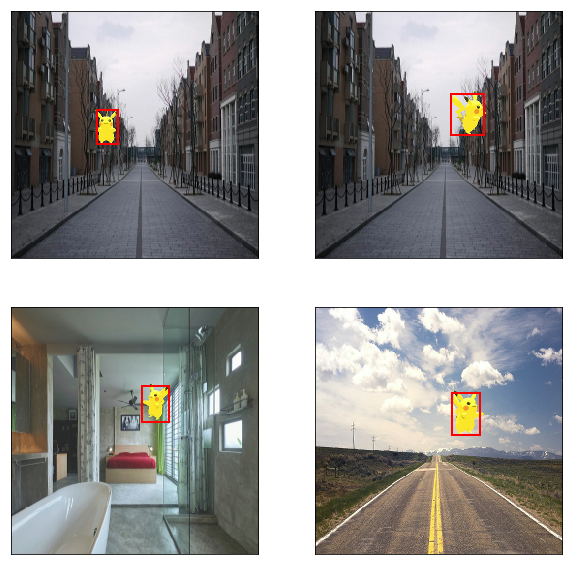

In [8]:
show_bounding_box_images(batch, nrows=2, ncols=2, data_shape=256, figsize=(10,10))

## <font color="green">SSD模型

### 锚框 
* mxnet生成锚框的方式还有点不懂

In [9]:
from mxnet.contrib.ndarray import MultiBoxPrior

sizes = [.5, .25, .1]
ratios = [1, 2, .5]
n = 40
sample = nd.random.normal(shape=(1,3,n,n))
anchor_boxes = MultiBoxPrior(sample, sizes=sizes, ratios=ratios)
print(anchor_boxes)


[[[-0.2375     -0.2375      0.2625      0.2625    ]
  [-0.1125     -0.1125      0.1375      0.1375    ]
  [-0.0375     -0.0375      0.0625      0.0625    ]
  ...
  [ 0.9375      0.9375      1.0375      1.0375    ]
  [ 0.63394666  0.8107233   1.3410534   1.1642767 ]
  [ 0.8107233   0.63394666  1.1642767   1.3410534 ]]]
<NDArray 1x8000x4 @cpu(0)>


In [10]:
anchor_boxes = anchor_boxes.reshape((n, n, -1, 4))
print(anchor_boxes.shape)
anchor_boxes[20, 20, :, :]

(40, 40, 5, 4)



[[0.2625     0.2625     0.7625     0.7625    ]
 [0.3875     0.3875     0.6375     0.6375    ]
 [0.46249998 0.46249998 0.5625     0.5625    ]
 [0.1589466  0.33572328 0.86605334 0.6892767 ]
 [0.33572328 0.1589466  0.6892767  0.86605334]]
<NDArray 5x4 @cpu(0)>

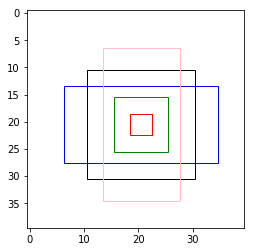

In [11]:
# 画出以(20, 20)为中心的anchor_box
colors = ['black', 'green', 'red', 'blue', 'pink']
plt.imshow(nd.ones((n, n, 3)).asnumpy())
box_20_20 = anchor_boxes[20, 20, :, :]
for i in range(box_20_20.shape[0]):
    rec = box_to_rec(box_20_20[i] * 40, colors[i], 1)
    plt.gca().add_patch(rec)

### 类别预测模块

In [12]:
def class_predictor(num_anchors_per_pixel, num_classes):
    '''
    num_anchors_per_pixel : int
        每个像素会生成几个锚框
    num_classes : int
        待预测类别数
    '''
    return gluon.nn.Conv2D(int(num_anchors_per_pixel*(num_classes+1)), kernel_size=3, padding=1)

def class_predictor(num_anchors_per_pixel, num_classes):
    '''
    num_anchors_per_pixel : 每个像素生成的锚框数
    num_classes : 总共待检测的类别数
    '''
    return gluon.nn.Conv2D(int(num_anchors_per_pixel * (num_classes + 1)), kernel_size=3, padding=1)

### 边框预测模块

In [13]:
def box_predictor(num_anchors_per_pixel):
    '''
    num_anchors_per_pixel : int
        每个像素会生生几个锚框
    '''
    return gluon.nn.Conv2D(int(num_anchors_per_pixel*4), kernel_size=3, padding=1)

def box_predictor(num_anchors_per_pixel):
    '''
    num_anchors_per_pixel : 每个像素生成的锚框数
    '''
    return gluon.nn.Conv2D(int(num_anchors_per_pixel * 4), kernel_size=3, padding=1)

### 减半模块

In [14]:
def down_sample(num_filters):
    module = gluon.nn.HybridSequential()
    for _ in range(2):
        module.add(
            gluon.nn.Conv2D(num_filters, kernel_size=3, padding=1),
            gluon.nn.BatchNorm(axis=1, epsilon=2e-5),
            gluon.nn.Activation('relu')
        )
    # 通过最大池化层来减半
    module.add(gluon.nn.MaxPool2D(pool_size=2, strides=2))
    return module 

def down_sample(num_filters):
    down = gluon.nn.HybridSequential()
    with down.name_scope():
        for _ in range(2):
            down.add(
                gluon.nn.Conv2D(num_filters, kernel_size=3, padding=1),
                gluon.nn.BatchNorm(axis=1, epsilon=2e-5),
                gluon.nn.Activation('relu')
            )
        down.add(gluon.nn.MaxPool2D(pool_size=2, strides=2))
    return down

### 多尺度融合模块
* 以类别预测为例，边框预测同理

In [15]:
# 尺度变化
sample = nd.zeros(shape=(1, 3, 256, 256))
cls_pred1 = class_predictor(num_anchors_per_pixel=5, num_classes=10)
cls_pred1.initialize()
y1 = cls_pred1(sample)
print("Scale 1 Output:", y1.shape)

downsample = down_sample(num_filters=10)
downsample.initialize()
sample = downsample(sample)
print("Down sample:", sample.shape)

cls_pred2 = class_predictor(num_anchors_per_pixel=3, num_classes=10)
cls_pred2.initialize()
y2 = cls_pred2(sample)
print("Scale 2 Output:", y2.shape)
# 可以看到不同尺度每次预测后的结果都不一样，因此我们定义多尺度融合模块，将不同尺度的输出融合到一起

Scale 1 Output: (1, 55, 256, 256)
Down sample: (1, 10, 128, 128)
Scale 2 Output: (1, 33, 128, 128)


In [16]:
def flatten_preds(preds):
    return preds.transpose((0, 2, 3, 1)).flatten()

def concat_preds(preds):
    return nd.concat(*preds, dim=1)

def flatten_preds(pred):
    return pred.transpose((0,2,3,1)).flatten()

def concat_preds(preds):
    return nd.concat(*preds, dim=1)

### 特征提取网络（backbone）
* 主流网络ResNet, DenseNet等都可以用来提取特征，这里简单Stack三个减半模块来构成一个特征提取网络

In [17]:
def body_net():
    body = gluon.nn.HybridSequential()
    with body.name_scope():
        for nfilters in [16, 32, 64]:
            body.add(down_sample(nfilters))
    return body

def body_net(): 
    body = gluon.nn.HybridSequential()
    with body.name_scope():
        for nfilters in [16, 32, 64]:
            body.add(down_sample(nfilters))
    return body

### 构建SSD主体网络
* 一个特征提取网络，三个减半模块，五个类别预测和边框预测模块。

In [18]:
def ssd_model(num_anchors_per_pixel, num_classes):
    down_samples = gluon.nn.Sequential()
    class_predictors = gluon.nn.Sequential()
    box_predictors = gluon.nn.Sequential()
    
    # add downsample moudle
    for _ in range(3):
        down_samples.add(down_sample(128))
        
    # add class predict and box predict module
    for _ in range(5):
        class_predictors.add(class_predictor(num_anchors_per_pixel, num_classes))
        box_predictors.add(box_predictor(num_anchors_per_pixel))
        
    ssd_model = gluon.nn.Sequential()
    with ssd_model.name_scope():
        ssd_model.add(body_net(), down_samples, class_predictors, box_predictors)
    return ssd_model

def ssd_model(num_anchors_per_pixel, num_classes):
    downsamples = gluon.nn.Sequential()
    class_predictors = gluon.nn.Sequential()
    box_predictors = gluon.nn.Sequential()
    
    for _ in range(3):
        downsamples.add(down_sample(128))
    
    for _ in range(5):
        class_predictors.add(class_predictor(num_anchors_per_pixel, num_classes))
        box_predictors.add(box_predictor(num_anchors_per_pixel))
    ssd_model = gluon.nn.Sequential()
    with ssd_model.name_scope():
        ssd_model.add(body_net(), downsamples, class_predictors, box_predictors)
    return ssd_model

In [19]:
# model = ssd_model(5, 1)
# model.initialize()
# model

### 构建前向函数

In [20]:
def ssd_forward(X, ssd_model, sizes, ratios, verbose):
    body_net, down_samples, class_predictors, box_predictors = ssd_model
    # prepare for concat
    anchors, class_preds, box_preds = [], [], []
    # feature extraction
    X = body_net(X)
    # downsample
    for i in range(5):
        anchors.append(MultiBoxPrior(X, sizes=sizes[i], ratios=ratios[i]))
        ### 注意要把flatten后的结果放进类别预测和边框预测
        class_preds.append(flatten_preds(class_predictors[i](X)))
        box_preds.append(flatten_preds(box_predictors[i](X)))
        
        if verbose:
            print("Use scale: sizes %s ratio %s, Out shape %s, Produce %d anchors."
                 % (sizes[i], ratios[i], X.shape, anchors[-1].shape[1]))
        
        if i < 3:
            X = down_samples[i](X)
        elif i == 3:
            X = nd.Pooling(data=X, global_pool=True, pool_type='max', kernel=(X.shape[2], X.shape[3]))
            
    ### 合并不同层的anchors
    ### **anchor**的输出样式 (1, 8000, 40) -> reshpe -> (height,width,num_anchors_per_pixel,4)
    ### 即使batch_size不为1此时输出的anchor的shape[0]也是1，因为不同的batch_size所生成的锚框是一样的
    ### class_preds的输出样式 (1, 55, 32, 32) -> (batch_size, num_anchors_per_pixel*(num_class+1), width, height)
    ### box_preds的输出样式 (1, 40, 32, 32) -> (batch_size, num_anchors_per_pixel*4, width, height)
    return (concat_preds(anchors), concat_preds(class_preds), concat_preds(box_preds))

def ssd_forward(X, ssd_model, sizes, ratios, verbose=False):
    body, downsamples, class_predictors, box_predictors = ssd_model
    # 主体网络输出
    X = body(X)
    # 定义合并数组，将来自不同尺度的结果进行合并
    anchors, class_preds, box_preds = [], [], []
    # 5个阶段的多尺度预测
    for i in range(5):
        # predict
        anchors.append(MultiBoxPrior(X, sizes=sizes[i], ratios=ratios[i]))
        # 保存的都是flatten的结果，便于后面将不同层的特征做合并
        class_preds.append(flatten_preds(class_predictors[i](X)))
        box_preds.append(flatten_preds(box_predictors[i](X)))
        
        # debug
        if verbose:
            # anchors[-1].shape[1]取最新append进去的，即当前生成锚框的个数
            print("Predict scale", i, "ratio", i, ",Output shape : ", X.shape, ", With", anchors[-1].shape[1], "anchors.")
        
        # downsample
        if i < 3:
            X = downsamples[i](X)
        elif i == 3:
            X = nd.Pooling(X, global_pool=True, pool_type='max', kernel=(X.shape[2], X.shape[3]))
    
    # 将来自不同尺度的结果进行合并
    return (concat_preds(anchors), concat_preds(class_preds), concat_preds(box_preds))

### 构建SSD模型

In [21]:
class SSD(gluon.nn.Block):
    def __init__(self, num_classes, verbose=False, **kwargs):
        super().__init__(**kwargs)
        self.anchor_sizes = [[.2, .272], [.37, .447], [.54, .619], [.71, .79], [.88, .961]]
        self.anchor_ratios = [[1, 2, .5]] * 5
        self.num_classes = num_classes 
        self.verbose = verbose
        
        # n + m - 1
        num_anchors_per_pixel = len(self.anchor_sizes[0]) + len(self.anchor_ratios[0]) - 1
        with self.name_scope():
            self.model = ssd_model(num_anchors_per_pixel, num_classes)
    
    def forward(self, X):
        anchors, class_preds, box_preds = ssd_forward(X, self.model, self.anchor_sizes, 
                                                      self.anchor_ratios, verbose=self.verbose)
        class_preds = class_preds.reshape(shape=(0, -1, int(self.num_classes+1)))
        return anchors, class_preds, box_preds
    
class SSD(gluon.nn.Block):
    def __init__(self, num_classes, verbose=False, **kwargs):
        super().__init__(*kwargs)
        self.anchor_sizes = [[.2, .272], [.37, .447], [.54, .619], [.71, .79], [.88, .961]]
        self.anchor_ratios = [[1, 2, .5]] * 5
        self.num_classes = num_classes 
        self.verbose = verbose
        
        num_anchors_per_pixel = len(self.anchor_sizes[0]) + len(self.anchor_ratios[0]) - 1 # m+n-1
        with self.name_scope():
            self.model = ssd_model(num_anchors_per_pixel, num_classes)
            
    def forward(self, X):
        anchors, class_preds, box_preds = ssd_forward(X, self.model, self.anchor_sizes, 
                                                      self.anchor_ratios, self.verbose)
        # 将对类别的预测信息还原回（batch_size，-1， num_class+1）的形式
        class_preds = class_preds.reshape(shape=(0, -1, int(self.num_classes+1)))
        return anchors, class_preds, box_preds

In [22]:
## 测试SSD模型
ssd_net = SSD(num_classes=1, verbose=True)
ssd_net.initialize()

In [23]:
data = batch.data[0]
anchors, class_preds, box_preds = ssd_net(data)
print("Out anchors : ", anchors.shape)
print("class preds : ", class_preds.shape)
print("box preds : ", box_preds.shape)
### 可以看到输出的anchors无论batch_size是多少最后结果的第一个维度都是1

Predict scale 0 ratio 0 ,Output shape :  (4, 64, 32, 32) , With 4096 anchors.
Predict scale 1 ratio 1 ,Output shape :  (4, 128, 16, 16) , With 1024 anchors.
Predict scale 2 ratio 2 ,Output shape :  (4, 128, 8, 8) , With 256 anchors.
Predict scale 3 ratio 3 ,Output shape :  (4, 128, 4, 4) , With 64 anchors.
Predict scale 4 ratio 4 ,Output shape :  (4, 128, 1, 1) , With 4 anchors.
Out anchors :  (1, 5444, 4)
class preds :  (4, 5444, 2)
box preds :  (4, 21776)


## <font color="green">训练

### MultiboxTarget
    * 主要用于处理具有标注的锚框（正框，IOU大于threshold）和背景锚框（负框，IOU小于threshold）之间的类别不平衡问题，并获取用于类别预测模块的每个锚框中的图片所代表的真实类别(cls_target)和用于边框预测的锚框和真实边框之间的偏移量(box_target)。
    * 返回的值：
        + box_target : 预测的边框和真实边框之间的偏移，即边框预测的真实值
            shape = （batch_size, num_anchors_per_pixel * 4）
        + box_mask : 用于遮掩不需要的负类锚框的掩码，与box_target一一对应
            shape = （batch_size, num_anchors_per_pixel * 4）
        + cls_taregt : 每个锚框所代表的真实类别信息，将真实标签转换为0表示背景，1表示类别1，以此类推...
            shape = (batch_size, num_anchors_per_pixel)

In [24]:
from mxnet.contrib.ndarray import MultiBoxTarget

def training_targets(anchors, labels, class_preds):
    class_preds = class_preds.transpose((0, 2, 1))
    return MultiBoxTarget(anchor=anchors, label=labels, cls_pred=class_preds)

In [25]:
# out = training_targets(anchors, batch.label[0], class_preds)

In [26]:
# out

**观察当前批量中有多少个锚框进入边框预测的损失函数**

In [27]:
# out[1].sum(axis=1, keepdims=False) / 4

### Focal Loss
* 用于处理类别不平衡时情况时的关注交叉熵损失函数，用于类别预测模块class_predictors

In [28]:
class FocalLoss(gluon.loss.Loss):
    def __init__(self, axis=-1, alpha=0.25, gamma=2, batch_axis=0, **kwargs):
        '''
        axis : int
            指定计算均值时的维度(最后一个维度)
        alpha : float
            比例系数
        gamma : float
            比例系数
        batch_axis : int
            batch_size所在的维度
        '''
        super().__init__(weight=None, batch_axis=batch_axis, **kwargs)
        self._axis = axis
        self._alpha = alpha
        self._gamma = gamma
        self._batch_axis =  batch_axis
    
    def hybrid_forward(self, F, preds, labels):   
        '''
        preds : NDArray
            指类别预测模块输出的预测比例 即ssd_net输出的class_preds shape=(batch_size, num_anchors, num_classes+1)
        labels : NDArray
            注意：指MultiboxTarget输出的label真实标签，即box_target，而非原始的从idx文件中的标签，因此可能与
        '''
        preds = F.softmax(preds) # 输出shape = (1, 5444, 2)
        pj = F.pick(data=preds, index=labels, axis=self._axis, keepdims=True)# 输出shape = (1, 5444, 1)
        loss = - self._alpha * ((1 - pj)**self._gamma) * pj.log()
        return loss.mean(axis=self._batch_axis, exclude=True)

In [29]:
cls_loss = FocalLoss()
cls_loss

FocalLoss(batch_axis=0, w=None)

### Smooth L1 Loss
* 平滑的L1损失函数，对误分较大边框样本的惩罚较小(L2系列的惩罚较大，因此不用)，用于边框偏移量预测模块box_predictors
* 我们利用mask只计算具有真实边框(即IOU>threshold)的锚框的损失，负例锚框不做考虑
* box_mask skip掉了一些我们不想学的bounding box

In [30]:
class SmoothL1Loss(gluon.loss.Loss):
    def __init__(self, batch_axis=0, **kwargs):
        super().__init__(weight=None, batch_axis=batch_axis, **kwargs)
        self._batch_axis = batch_axis

    def hybrid_forward(self, F, preds, labels, mask):
        '''
        preds : 边框预测模块的预测值，属于预测值
        labels : 锚框与真实边框之间的偏移量，属于真实值
        mask : 用于屏蔽不需要的锚框的掩码
        '''
        loss = F.smooth_l1((preds - labels) * mask, scalar=1.0)
        return loss.mean(axis=self._batch_axis, exclude=True)

In [31]:
box_loss = SmoothL1Loss()
box_loss

SmoothL1Loss(batch_axis=0, w=None)

### 评估函数

In [32]:
cls_metric = metric.Accuracy()
box_metric = metric.MAE() #平均绝对误差(L1) MSE是平均平方误差(L2) 

### 针对样本类别较少的情况
* CUDA加速需要每张图片至少3个label，但是我们可能每张图片只有一个label，因此，我们需要对label_shape进行padding，我们padding的值全为-1
* 当样本类别数大于3时，我们可能需要将reshape的值变大一点

In [33]:
train_data.reshape(label_shape=(3, 5))
valid_data = train_data.sync_label_shape(valid_data, verbose=False)

### 训练

In [34]:
from time import time

def train_ssd(ssd_net, train_iter, epochs, batch_size, lr, wd, lr_period=0, lr_decay=0, ctx=mx.gpu()):
    ssd_net.initialize(init=mx.init.Xavier(rnd_type='gaussian', factor_type='in', magnitude=2.), ctx=ctx)
    # weight_decay l2_regularization
    trainer = gluon.Trainer(ssd_net.collect_params(), 'sgd', {'learning_rate': 0.1, 'wd': 5e-4})
    
    niter = 0
    moving_loss = .0
    smooth_const = .9
    
    for epoch in range(epochs):
        # reset
        train_iter.reset()
        # 每次会reset为0
        cls_metric.reset()
        box_metric.reset()
        start = time()
        for i, batch in enumerate(train_iter):
            data = batch.data[0].as_in_context(ctx)
            labels = batch.label[0].as_in_context(ctx)
            with autograd.record():
                # 网络输出：锚框，锚框中含有的物体，预测新的锚框 
                anchors, cls_preds, box_preds = ssd_net(data)
                box_target, box_mask, cls_target = training_targets(anchors=anchors, labels=labels, class_preds=cls_preds)
                # 类别预测的损失
                    loss1 = cls_loss(cls_preds, cls_target)
                # 边框预测的损失 
                loss2 = box_loss(box_preds, box_target, box_mask)
                # 这两个loss应该加上weight multi-loss
                loss = loss1 + loss2
                
                # update moving loss
                niter += 1
                curr_loss = nd.mean(loss).asscalar()
                moving_loss = smooth_const * moving_loss + (1 - smooth_const) * curr_loss
                estimated_loss = moving_loss / (1 - smooth_const**niter)
                
            loss.backward()
            trainer.step(batch_size)
        
            # update metric
            cls_metric.update([cls_target], [cls_preds.transpose((0, 2, 1))])
            box_metric.update([box_target], [box_preds * box_mask])
            
        print("[Epoch %d] Train Moving loss %.5f, Train %s %.5f, %s %.5f, Time Consume %.5f sec" 
              % (epoch+1, estimated_loss, *cls_metric.get(), *box_metric.get(), time() - start))

In [35]:
ctx = mx.gpu()
ssd_net = SSD(num_classes=num_classes, verbose=False)

In [36]:
train_ssd(ssd_net, train_iter=train_data, epochs=100, batch_size=batch_size, lr=.1, wd=5e-4, ctx=ctx)

c:\liang-workspace\liang\lib\site-packages\mxnet\recordio.py:370: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  header = header._replace(label=np.fromstring(s, np.float32, header.flag))


[Epoch 1] Train Moving loss 0.01529, Train accuracy 0.91071, mae 0.00512, Time Consume 33.58300 sec
[Epoch 2] Train Moving loss 0.00833, Train accuracy 0.98716, mae 0.00460, Time Consume 11.34200 sec
[Epoch 3] Train Moving loss 0.00663, Train accuracy 0.99156, mae 0.00410, Time Consume 11.49600 sec
[Epoch 4] Train Moving loss 0.00579, Train accuracy 0.99316, mae 0.00395, Time Consume 11.56900 sec
[Epoch 5] Train Moving loss 0.00559, Train accuracy 0.99389, mae 0.00395, Time Consume 10.84600 sec
[Epoch 6] Train Moving loss 0.00499, Train accuracy 0.99440, mae 0.00383, Time Consume 11.12100 sec
[Epoch 7] Train Moving loss 0.00477, Train accuracy 0.99477, mae 0.00374, Time Consume 10.79200 sec
[Epoch 8] Train Moving loss 0.00461, Train accuracy 0.99501, mae 0.00370, Time Consume 11.31100 sec
[Epoch 9] Train Moving loss 0.00445, Train accuracy 0.99531, mae 0.00360, Time Consume 10.50800 sec
[Epoch 10] Train Moving loss 0.00410, Train accuracy 0.99543, mae 0.00352, Time Consume 10.52300 sec

[Epoch 83] Train Moving loss 0.00213, Train accuracy 0.99703, mae 0.00261, Time Consume 10.53400 sec
[Epoch 84] Train Moving loss 0.00216, Train accuracy 0.99684, mae 0.00268, Time Consume 10.49900 sec
[Epoch 85] Train Moving loss 0.00223, Train accuracy 0.99689, mae 0.00264, Time Consume 10.57300 sec
[Epoch 86] Train Moving loss 0.00208, Train accuracy 0.99699, mae 0.00259, Time Consume 10.64100 sec
[Epoch 87] Train Moving loss 0.00232, Train accuracy 0.99679, mae 0.00265, Time Consume 10.51900 sec
[Epoch 88] Train Moving loss 0.00217, Train accuracy 0.99693, mae 0.00258, Time Consume 10.49800 sec
[Epoch 89] Train Moving loss 0.00194, Train accuracy 0.99716, mae 0.00248, Time Consume 10.54400 sec
[Epoch 90] Train Moving loss 0.00209, Train accuracy 0.99710, mae 0.00255, Time Consume 10.56100 sec
[Epoch 91] Train Moving loss 0.00204, Train accuracy 0.99703, mae 0.00255, Time Consume 10.52600 sec
[Epoch 92] Train Moving loss 0.00209, Train accuracy 0.99701, mae 0.00262, Time Consume 10.

## <font color="green"> 预测

In [48]:
# 标准的读入图片后的处理函数
def process_predicted_image(fname, resize):
    # read the image
    with open(fname, 'rb') as f:
        img = image.imdecode(f.read())
    # resize to data_shape
    data = image.imresize(img, resize, resize)
    # minus rgb mean
    data = data.astype(np.float32) - rgb_mean
    # expand to 4 shapes
    return data.transpose((2, 0, 1)).expand_dims(axis=0), img

### NMS(非极大值抑制)
* Non Maximum Suppression

对于IOU比较高的多个边框，我们使用非极大值抑制来只保留预测概率最高的那个，这个方法在MultiboxDetection中实现了

In [49]:
from mxnet.contrib.ndarray import MultiBoxDetection

def predict(x):
    # 从训练好的模型中提取预测锚框，类别预测信息，边框预测信息
    anchors, cls_preds, box_preds = ssd_net(x.as_in_context(ctx))
    cls_probs = nd.SoftmaxActivation(
        cls_preds.transpose((0, 2, 1)), mode='channel')
    # 我们可以使用clip=True来剔除掉超过边界框大小的锚框
    return MultiBoxDetection(cls_probs, box_preds, anchors,
                             force_suppress=True, clip=True) 

### MultiBoxDetection

``MultiBoxDetection``会输出所有锚框信息，每个锚框由以下形式的六元组构成：
* $[class\_id, confidence, xmin, ymin, xmax, ymax]$
    * $class\_id$ : 该锚框预测得到的的类别，**其中值为-1表示这个边框要么只含有背景，要么被$box\_mask$屏蔽掉了**
    * $confidence$ : 得到该预测类别的置信值
    * $xmin, ymin, xmax, ymax$分别表示该锚框的左上角和右下角坐标

In [50]:
x, img = process_predicted_image('pikachu.jpg', resize=256)
out = predict(x)
print(out.shape)
# 展示五个结果
print(out[0][:5])

(1, 5444, 6)

[[0.         0.6589861  0.51900464 0.32739908 0.66924316 0.55877656]
 [0.         0.6324331  0.3649175  0.47249994 0.4903557  0.71480584]
 [0.         0.6083017  0.5109689  0.49862975 0.6619253  0.7290674 ]
 [0.         0.6001618  0.38765833 0.5269102  0.5116184  0.76411724]
 [0.         0.5719995  0.70402944 0.09816786 0.8515613  0.32469103]]
<NDArray 5x6 @gpu(0)>


最后将预测置信度超过某个阈值边框画出来

[0.         0.6589861  0.51900464 0.32739908 0.66924316 0.55877656]
[0.         0.6324331  0.3649175  0.47249994 0.4903557  0.71480584]
[0.         0.6083017  0.5109689  0.49862975 0.6619253  0.7290674 ]
[0.         0.6001618  0.38765833 0.5269102  0.5116184  0.76411724]
[0.         0.5719995  0.70402944 0.09816786 0.8515613  0.32469103]
[0.         0.54439014 0.7359681  0.5088823  0.8797226  0.7495631 ]


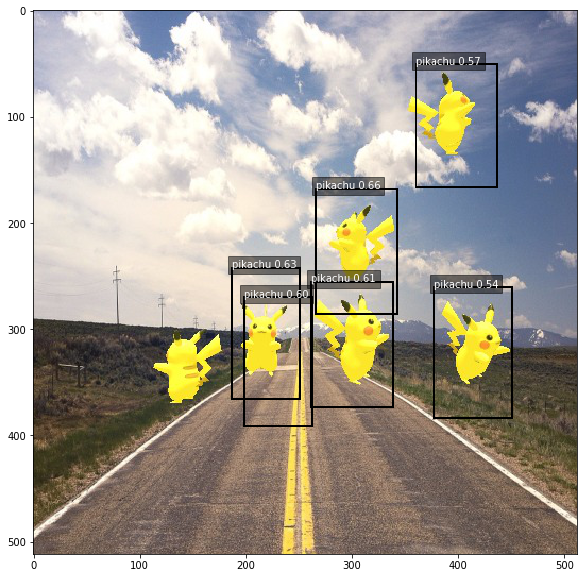

In [52]:
mlt.rcParams['figure.figsize'] = (10,10)

def display(img, out, threshold=0.5):
    # 显示图片
    plt.imshow(img.asnumpy())
    # 遍历MultiboxDetectio输出的所有六元组
    for row in out:
        # 转换为numpy
        row = row.asnumpy()
        class_id, score = int(row[0]), row[1]
        if class_id < 0 or score < threshold:
            continue
        print(row)
        # 在这里皮卡丘的类别又是1
        color = colors[class_id%len(colors)]
        # 乘以该np.array数组是为了将0-1的bb扩展到图片的尺寸[512, 512, 512, 512]
        box = row[2:6] * np.array([img.shape[0],img.shape[1]]*2)
        rect = box_to_rec(nd.array(box), color, 2)
        # 将bounding_box添加到图片上
        plt.gca().add_patch(rect)

        text = class_name[class_id]
        plt.gca().text(box[0], box[1],
                       '{:s} {:.2f}'.format(text, score),
                       bbox=dict(facecolor=color, alpha=0.5),
                       fontsize=10, color='white')
    plt.show()

display(img, out[0], threshold=0.5)

## 进一步的细节

* **锚框的大小和长宽比是如何选取的**
* **MultiBoxTarget里我们没有采样负例**
    + <font color="red">对，找个问题我也注意到了，说好的按负类预测值排序取一部分负类呢？</red>
* **分类和回归损失我们直接加起来了，并没有给予权重**
* **在展示的时候如何选取阈值threshold**

以上问题在工程实现的时候都需要考虑在内。